In [19]:
# This notebook is following along from this notebook https://www.kaggle.com/khoongweihao/covid-19-novel-coronavirus-eda-forecasting-cases#Data-Import,-Preprocessing-and-EDA

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from fbprophet import Prophet
import pycountry
import plotly.express as px
from collections import namedtuple

In C:\Users\James\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\James\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\James\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\James\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\James\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# read csv's
df = pd.read_csv('Covid 19/covid_19_data.csv', parse_dates=['Last Update'])
# rename column names for convenience
df.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'},inplace=True)
df_confirmed = pd.read_csv('Covid 19/time_series_covid_19_confirmed.csv')
df_recovered = pd.read_csv('Covid 19/time_series_covid_19_recovered.csv')
df_deaths = pd.read_csv('Covid 19/time_series_covid_19_deaths.csv')

df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)

In [3]:
df_recovered.head()

,Province/State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,21135,21216,21254,21454,22456,22824,23151,23273,23634,23741
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,1881,1946,2014,2062,2091,2137,2214,2264,2311,2352
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,13124,13743,14019,14295,14792,15107,15430,15744,16051,16400
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,803,803,803,803,803,803,803,803,803,803
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,118,118,118,118,124,124,199,210,221,221


In [4]:
df.shape

(68558, 8)

In [5]:
df.head()

,SNo,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


In [6]:
# by date, country view 
d=df.groupby(['Date','Country', 'Province/State']).sum().reset_index()
d


,Date,Country,Province/State,SNo,Confirmed,Deaths,Recovered
0,01/22/2020,Hong Kong,Hong Kong,13,0.0,0.0,0.0
1,01/22/2020,Macau,Macau,21,1.0,0.0,0.0
2,01/22/2020,Mainland China,Anhui,1,1.0,0.0,0.0
3,01/22/2020,Mainland China,Beijing,2,14.0,0.0,0.0
4,01/22/2020,Mainland China,Chongqing,3,6.0,0.0,0.0
...,...,...,...,...,...,...,...
44116,07/20/2020,Ukraine,Vinnytsia Oblast,68526,2317.0,40.0,1736.0
44117,07/20/2020,Ukraine,Volyn Oblast,68532,3281.0,75.0,2143.0
44118,07/20/2020,Ukraine,Zakarpattia Oblast,68553,4440.0,155.0,1554.0
44119,07/20/2020,Ukraine,Zaporizhia Oblast,68554,678.0,20.0,551.0


In [7]:
# Query df by country of cases by last update
df.query('Country=="Mainland China"').groupby('Last Update')[['Confirmed','Deaths','Recovered']].sum().reset_index()

,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22 17:00:00,547.0,17.0,28.0
1,2020-01-23 17:00:00,639.0,18.0,30.0
2,2020-01-24 17:00:00,916.0,26.0,36.0
3,2020-01-25 17:00:00,1399.0,42.0,39.0
4,2020-01-26 16:00:00,2062.0,56.0,49.0
...,...,...,...,...
897,2020-07-17 04:34:50,83613.0,4634.0,78719.0
898,2020-07-18 04:34:45,83613.0,4634.0,78719.0
899,2020-07-19 04:34:58,83613.0,4634.0,78719.0
900,2020-07-20 05:34:40,83613.0,4634.0,78719.0


In [8]:
df.query('Date == "01/22/2020"').groupby('Country')[['Confirmed','Deaths','Recovered']].sum().reset_index()

,Country,Confirmed,Deaths,Recovered
0,Hong Kong,0.0,0.0,0.0
1,Japan,2.0,0.0,0.0
2,Macau,1.0,0.0,0.0
3,Mainland China,547.0,17.0,28.0
4,South Korea,1.0,0.0,0.0
5,Taiwan,1.0,0.0,0.0
6,Thailand,2.0,0.0,0.0
7,US,1.0,0.0,0.0


In [9]:
df.loc[df['Date']=='01/22/2020']['Country'].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea'], dtype=object)

In [10]:
# Sort by country for overall cases
df.groupby('Country')[['Confirmed', 'Deaths','Recovered']].sum().reset_index()

,Country,Confirmed,Deaths,Recovered
0,Azerbaijan,1.0,0.0,0.0
1,"('St. Martin',)",2.0,0.0,0.0
2,Afghanistan,1684683.0,40510.0,626252.0
3,Albania,164738.0,4804.0,100822.0
4,Algeria,996868.0,70037.0,632529.0
...,...,...,...,...
218,Western Sahara,831.0,56.0,592.0
219,Yemen,55537.0,14427.0,18336.0
220,Zambia,101446.0,1699.0,69842.0
221,Zimbabwe,34870.0,665.0,8607.0


## Visualizations

In [13]:
confirmed = df.groupby('Date').sum()['Confirmed'].reset_index()
deaths = df.groupby('Date').sum()['Deaths'].reset_index()
recovered = df.groupby('Date').sum()['Recovered'].reset_index()

In [21]:
fig = go.Figure()
fig.add_trace(go.Bar(x=confirmed['Date'],
                    y=confirmed['Confirmed'],
                    name='Confirmed',
                    marker_color='blue'))
fig.add_trace(go.Bar(x=deaths['Date'],
                    y=deaths['Deaths'],
                    name='Deaths',
                    marker_color='Red'))
fig.add_trace(go.Bar(x=recovered['Date'],
                    y=recovered['Recovered'],
                    name='Recovered',
                    marker_color='Green'))

fig.update_layout(
    title='Corona Virus Cases Worldwide',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of Cases',
        titlefont_size = 16,
        tickfont_size=14,),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1)
fig.show()

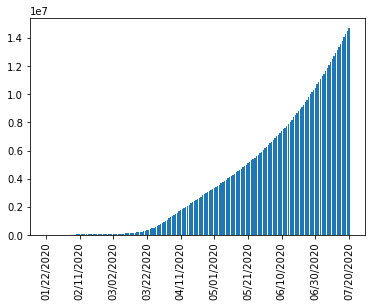

In [45]:
import matplotlib.ticker as plticker
fig,ax = plt.subplots()
ax.bar(confirmed['Date'], confirmed['Confirmed'])
loc = plticker.MultipleLocator(base=20)
ax.xaxis.set_major_locator(loc)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

In [24]:
confirmed.dtypes

Date          object
Confirmed    float64
dtype: object